### 梯度下降过程
#### 1. 二维平面内的

In [49]:
import torch

def default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')   
    if torch.backends.mps.is_available():
        return torch.device('mps')
    return torch.device('cpu')

device = default_device()

In [50]:
import matplotlib.pyplot as plt

In [51]:
def f(x):
    return x**2 + 4 * x + 1

x = torch.tensor(-10.0, requires_grad=True, device=device)
learning_rate = 0.8

xs = []
ys = []
for i in range(100):
    y = f(x)
    xs.append(x.item())
    ys.append(y.item())
    y.backward()
    with torch.no_grad():
      x.data -= learning_rate * x.grad
      x.grad.zero_()

print(f'最终参数：{x.item()}')


最终参数：-2.0


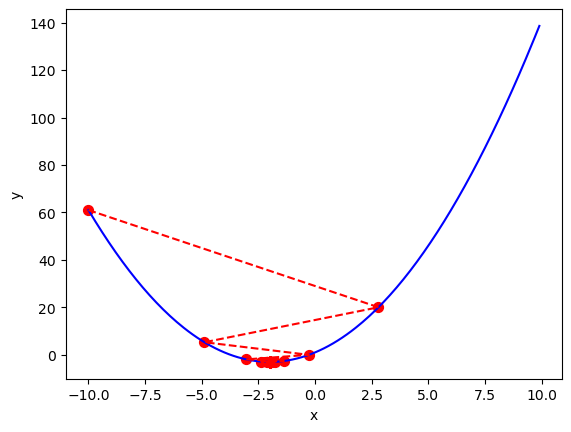

In [52]:
x_origin = torch.arange(-10, 10, 0.1)
y_origin = f(x_origin)
plt.plot(x_origin.numpy(), y_origin.numpy(), 'b-')

plt.plot(xs, ys, 'r--')
plt.scatter(xs, ys, s = 50, c='r')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


#### 2. 三维平面内的梯度下降

In [53]:
def f(x, y):
    return x**2 + 2 * y**2

x = torch.tensor(-10.0, requires_grad=True, device=device)
y = torch.tensor(-10.0, requires_grad=True, device=device)

xs = []
ys = []
zs = []

learning_rate = 0.1


In [54]:
for i in range(100):
    z = f(x, y)
    xs.append(x.item())
    ys.append(y.item())
    zs.append(z.item())
    z.backward()
    with torch.no_grad():
        x.data -= learning_rate * x.grad
        y.data -= learning_rate * y.grad
        x.grad.zero_()
        y.grad.zero_()
        
print(f'最终参数：x={x.item()}, y={y.item()}')

最终参数：x=-2.0370367614930274e-09, y=-6.533180924230175e-22


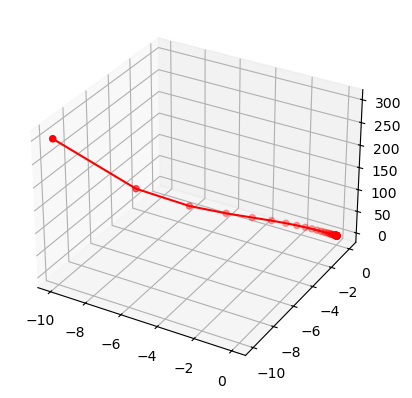

In [55]:
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, ys, zs, 'r-')
ax.scatter(xs, ys, zs, c='r')
plt.show()

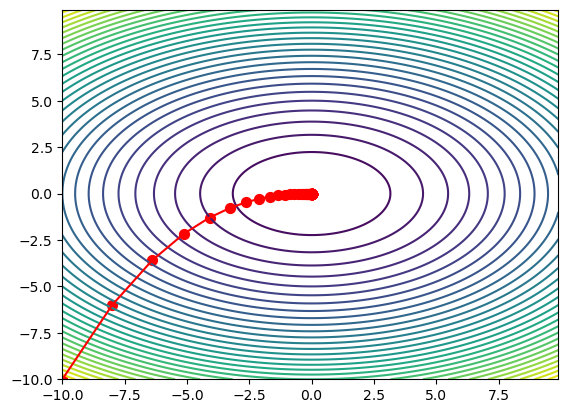

In [56]:
X, Y = torch.meshgrid(torch.arange(-10, 10, 0.1), torch.arange(-10, 10, 0.1), indexing='ij')
Z = f(X, Y)

plt.contour(X.numpy(), Y.numpy(), Z.numpy(), levels=30)

plt.plot(xs, ys, 'r-')
plt.scatter(xs, ys, c='r', s=50)
plt.show()

#### 优化器对比

In [57]:
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim

In [58]:
def f(x, y):
    return x**2 + 2 * y**2

n_samples = 1000
X = torch.rand(n_samples)
Y = torch.rand(n_samples)
Z = f(X, Y) + torch.randn(n_samples)

dataset = torch.stack([X, Y, Z], dim=1)


In [59]:
train_size = int(n_samples * 0.8)
test_size = n_samples - train_size
train_dataset, test_dataset = random_split(dataset, lengths=[train_size, test_size])


train_dataloader = DataLoader(
  TensorDataset(train_dataset.dataset.narrow(1,0,2), train_dataset.dataset.narrow(1,2,1)), 
  batch_size=32, shuffle=False)
test_dataloader = DataLoader(
  TensorDataset(test_dataset.dataset.narrow(1,0,2), test_dataset.dataset.narrow(1,2,1)), 
  batch_size=32, shuffle=False)


In [60]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.output = nn.Linear(8, 1)
        
    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)


In [ ]:
loss_fn = nn.MSELoss()

opt_labels = ['SGD', 'Momemtum', 'Adagrad', 'RMSprop', 'Adadelta', 'Adam']
models = [Model() for _ in range(len(opt_labels))]

SGD = optim.SGD(models[0].parameters(), lr=learning_rate)
Momentum = optim.SGD(models[1].parameters(), lr=learning_rate, momentum=0.8, nesterov=True)
Adagrad = optim.Adagrad(models[2].parameters(), lr=learning_rate)
RMSprop = optim.RMSprop(models[3].parameters(), lr=learning_rate)
Adadelta = optim.Adadelta(models[4].parameters(), lr=learning_rate)
Adam = optim.Adam(models[5].parameters(), lr=learning_rate)

optimizers = [SGD, Momentum, Adagrad, RMSprop, Adadelta, Adam]

train_losses_history = [[] for _ in range(len(opt_labels))]
test_losses_history = [[] for _ in range(len(opt_labels))]
n_epochs = 50
learning_rate = 0.1


In [62]:
for epoch in range(n_epochs):
    train_losses = [0 for _ in range(len(opt_labels))]
    for i, (X_batch, Y_batch) in enumerate(train_dataloader):
        for j, model in enumerate(models):
            model.train()
            optimizer = optimizers[j]
            optimizer.zero_grad()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            loss.backward()
            optimizer.step()
            train_losses[j] += loss.item()

    test_losses = [0 for _ in range(len(opt_labels))]     
    for i, (X_batch, Y_batch) in enumerate(test_dataloader):
        for j, model in enumerate(models):
            model.eval()
            Y_pred = model(X_batch)
            loss = loss_fn(Y_pred, Y_batch)
            test_losses[j] += loss.item()

    for i in range(len(opt_labels)):
        train_losses[i] /= len(train_dataloader)
        train_losses_history[i].append(train_losses[i])
        test_losses[i] /= len(test_dataloader)
        test_losses_history[i].append(test_losses[i])
    


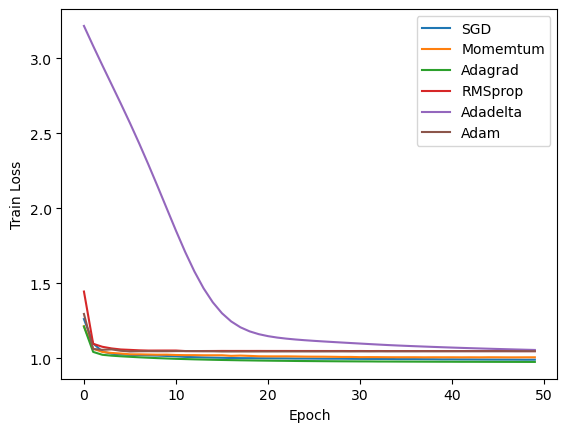

In [63]:
for i, l_his in enumerate(train_losses_history):
    plt.plot(l_his, label=opt_labels[i])
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()

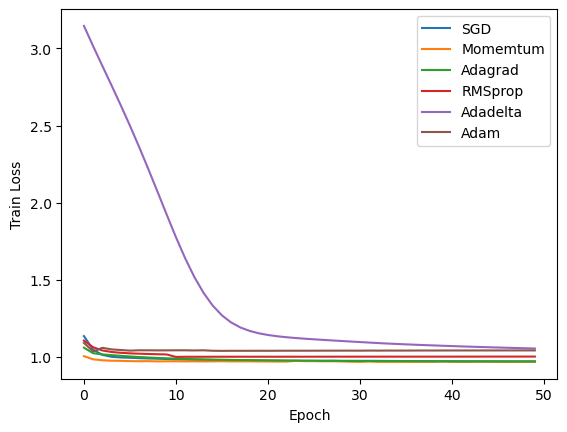

In [64]:
for i, l_his in enumerate(test_losses_history):
    plt.plot(l_his, label=opt_labels[i])
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.show()